# load the data

In [9]:
import pandas as pd

training_data = pd.read_csv("train.csv")

price_labels = ["low", "medium", "high"]

training_data["PriceCategory"], bins = pd.qcut(
    training_data["SalePrice"],
    q=3,
    labels=price_labels,
    retbins=True,
    duplicates="drop"
)

X = training_data.drop(columns=["Id", "SalePrice", "PriceCategory"])
y = training_data["PriceCategory"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


# preprocess the data

In [10]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# preprocess and convert to DataFrame for viewing
X_processed = preprocessor.fit_transform(X)
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
all_features = list(numeric_features) + list(cat_features)
X_processed_df = pd.DataFrame(X_processed.toarray(), columns=all_features)


# test various models and select the best

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel

# 1️⃣ Build a pipeline with a *placeholder* "selector" step
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("variance", VarianceThreshold(threshold=0.0)),
    ("selector", "passthrough"),      # will be replaced by GridSearchCV
    ("classifier", LogisticRegression(solver="lbfgs", max_iter=500))
])

# 2️⃣ Tell GridSearchCV which options to try for "selector"
param_grid = {
    "selector": [
        "passthrough",
        SelectKBest(score_func=f_classif, k=100),
        SelectFromModel(
            LogisticRegression(
                penalty="l1",
                solver="saga",
                max_iter=10000
            )
        ),
    ],
}

# 3️⃣ Wrap the pipeline in GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,             # 5-fold cross-validation
    scoring="roc_auc_ovr",
    n_jobs=-1         # use all cores (optional, speeds things up)
)

# 4️⃣ Fit the whole thing
grid.fit(X_train, y_train)

# 5️⃣ Get the best pipeline (with the best selector choice)
best_pipeline = grid.best_estimator_

print("Best ROC AUC (OvR):", grid.best_score_)
print("Best selector:", grid.best_params_["selector"])

results = pd.DataFrame(grid.cv_results_)

# Show selector, mean score, std, and rank
summary = results[[
    "rank_test_score",
    "param_selector",
    "mean_test_score",
    "std_test_score"
]]

summary = summary.sort_values("rank_test_score")


Best ROC AUC (OvR): 0.9430913424753908
Best selector: SelectKBest(k=100)


# predict on the test data

In [20]:
y_pred_cat = best_pipeline.predict(X_test)

# Take a look at a few predictions vs actual
predictions_vs_actual = pd.DataFrame({
    "ActualCategory": y_test.values,
    "PredictedCategory": y_pred_cat
})

predictions_vs_actual["Correct"] = predictions_vs_actual["ActualCategory"] == predictions_vs_actual["PredictedCategory"]


# evaluate the model

              precision    recall  f1-score   support

        high       0.86      0.90      0.88        94
         low       0.90      0.92      0.91       110
      medium       0.79      0.73      0.76        88

    accuracy                           0.86       292
   macro avg       0.85      0.85      0.85       292
weighted avg       0.85      0.86      0.85       292



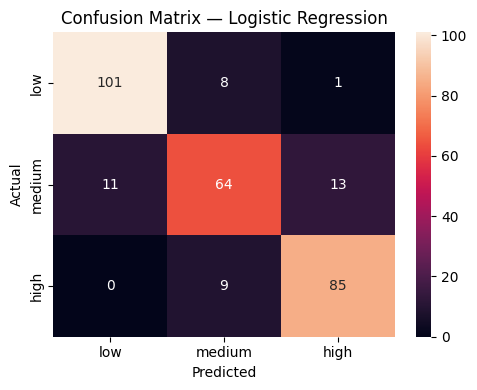

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test.values, y_pred_cat))

cm = confusion_matrix(y_test.values, y_pred_cat, labels=price_labels)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=price_labels,
    yticklabels=price_labels
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Logistic Regression")
plt.tight_layout()
plt.show()